## Sprint2 Generative Adversarial Networks

#### 1.このSprintについて

##### Sprintの目的 
GANの枠組みを学ぶ  
論文実装によりGANの理解を深める

##### どのように学ぶか 
雛形を元にKeras実装を完成させることで学びます。

#### 2.GANの基本
GAN（Generative Adversarial Networks, 敵対的生成ネットワーク）は生成モデルの一種で、2つのニューラルネットワークを組み合わせることで学習します。様々な改良が加えられたGANが登場していますが、ここでは2014年にGoodfellowが発表した最初のGAN（VanillaGAN）[1]を題材に学びます。

[1] Goodfellow, I. J., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., and Bengio, Y. (2014). Generative adversarial nets. In NIPS’2014. 

https://arxiv.org/pdf/1406.2661.pdf

#### GeneratorとDiscriminator 
GANは Generator（生成器） と Discriminator（判別器） の2つのニューラルネットワークを使用します。
Generatorはノイズを受け取り、訓練データと同じようなデータを出力します。
一方、Discriminatorは画像を受け取り、それがGeneratorが生成したものか訓練データのものかを分類します。

##### ニューラルネットワークの構造 
各ニューラルネットワークの構造はVanillaGANの論文中では言及されていません。任意の構造を用いることができますが、上手く生成するための構造が多数の論文にまとめられています。その結果、中間層の活性化関数には LeakyReLU の利用が一般的です。通常のReLUは負の値に対して0を出力しますが、LeakyReLUは小さな負の値を返します。

また、GeneratorにはBatchNormalizationを利用することが多いです。
CNNを用いたものは DCGAN (Deep Convolutional Generative Adversarial Networks) とも呼ばれます。

##### 学習アルゴリズム 
学習アルゴリズムは次のようになります。GeneratorとDiscriminatorを交互に学習していきます。学習時にはミニバッチ単位での更新を行います。
Generatorにノイズを入力し、データを生成する。  
Discriminatorに生成データと偽物であるというラベルを入力し、Discriminatorの重みを更新する。  
Discriminatorに訓練データと本物であるというラベルを入力し、Discriminatorの重みを更新する。  
Discriminatorに生成データと本物であるというラベルを入力し、Generatorの重みを更新する。  
1から4を繰り返す。  

4ではGeneratorとDiscriminatorを繋がったモデルとして扱い、バックプロパゲーションを行います。Discriminatorの重みは更新せず、Generatorの重みのみ更新します。一方で2,3ではDiscriminatorの重みのみ更新します。
このようにすることで、GeneratorはDiscriminatorに見破られないようになり、DiscriminatorはGeneratorを見破れるようになります。2つのニューラルネットワークが敵対しているように見えることが名称の由来になっています。
なお、GeneratorとDiscriminatorの更新回数の比率を1対1ではなくすることもあります。

##### 損失関数 
GANの損失関数は次のようになっています。

minGmaxDV(D,G)=Ex∼pdata(x)[logD(x)]+Ez∼pz(z)[log(1−D(G(z)))]

D: Discriminator

G: Generator

x: 訓練データ

z: ノイズ

Generatorはこれを最小化、Discriminatorはこれを最大化しようと学習します。
##### 《Discriminatorの学習時》
第1項は訓練データをDiscriminatorに入力して得られる値で、本物である確率（0から1）の対数です。本物と判別できた時ほど大きな値です。  
第2項は生成データをDiscriminatorに入力して得られる値で、偽物である確率（0から1）の対数です。偽物と判別できた時ほど大きな値です。
第1項と第2項の和を最大化することで、正しく判別できるようになります。対数を用いることで偽物である場合の絶対値を大きくしています。

#### 《Generatorの学習時》
Generatorに関係するのは第2項のみです。生成データをDiscriminatorに入力して得られる値で、偽物である確率（0から1）の対数です。偽物であるほど大きな値です。  
第2項を最小化することで、偽物だと見抜かれない高精度の生成が行えるようになります。

##### ノイズ 
Generatorへの入力としてノイズを作成する必要がありますが、これは事前分布 
pg(z)からバッチサイズ分サンプリングします。事前分布には正規分布を用いることが一般的です。ノイズは例えば100次元程度のものを使います。

#### 3.VanillaGANのKeras実装
VanillaGANのKeras実装を雛形を元に完成させていきます。MNISTを学習し、手書き数字を生成するモデルを作ります。

##### VanillaGANの雛形 
以下の雛形にコードを書き加えていきます。Kerasのfunctional APIを使用して記述されています。
なお、Kerasのバージョンは2.2.5で動作確認してあります。

In [1]:
from keras.datasets import mnist
from keras.layers import BatchNormalization, Dense, Flatten, Input, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

from IPython import display
import matplotlib.pyplot as plt
import numpy as np

import os

C:\Users\anai\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 【問題1】ノイズの作成 
Generatorに入力するノイズを作成するcreate_noiseメソッドを完成させてください。
このメソッドは「ミニバッチのサイズ×潜在変数の次元数」のndarrayを返すことが求められます。np.random.normalを用いてください。

### 【問題2】Discriminatorの作成 
DiscriminatorのModelインスタンスを作成するdiscriminator_modelメソッドを完成させてください。
画像を受け取り、2値分類を行うモデルです。出力層を合わせて3層程度の全結合層としてください。
中間層の活性化関数はLeakyReLUを用いてください。

### 【問題3】GeneratorとDiscriminatorを繋げる 
Generatorを学習させるにはGeneratorとDiscriminatorを繋げたModelインスタンスを作成する必要があります。
そのためのadversarial_modelメソッドを完成させてください。
雛形のこのメソッド中ではself.generatorとself.discriminatorをDenseクラスなどと同様に利用することが可能です。

### 【問題4】学習 
VanillaGANを学習し、生成された画像を確認してください。本物に近い生成を行うには時間がかかりますので、2000ステップ程度で学習が進んでいることを見てください。
学習過程では例えば次のような画像が生成されます。

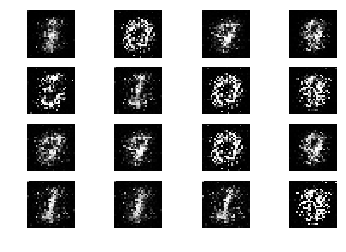

1900 step, [D loss: 0.702935] [G loss: 0.732103]


In [12]:
from keras.datasets import mnist
from keras.layers import BatchNormalization, Dense, Flatten, Input, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

from IPython import display
import matplotlib.pyplot as plt
import numpy as np

import os

class VanillaGAN():
    """
    VanillaGAN

    Goodfellow, I. J., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., and Bengio, Y. (2014). Generative adversarial nets. In NIPS’2014. https://arxiv.org/pdf/1406.2661.pdf

    Parameters
    ----------------
    img_shape : tuple of int
        生成する画像の形。順番は（縦, 幅, チャンネル数）。(default : (28, 28, 1))
    noise_dim : int
        潜在変数の次元数 (default : 100)
    """
    def __init__(self, img_shape=(28, 28, 1), noise_dim=100):
        self.img_shape = img_shape
        self.noise_dim = noise_dim
        self.optimizer = Adam(lr=0.0002, beta_1=0.5)
        self.compile_models()

    def compile_models(self):
        """
        Modelインスタンスのコンパイルを行う
        """
        self.discriminator = self.discriminator_model()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=self.optimizer,
            metrics=['accuracy'])

        self.adversarial = self.adversarial_model()
        self.adversarial.compile(loss='binary_crossentropy', optimizer=self.optimizer)

    def generator_model(self):
        """
        GeneratorのModelインスタンスを作る
        """
        noise = Input(shape=(self.noise_dim,))
        x = Dense(128, input_dim=self.noise_dim)(noise)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(256)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(1024)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(np.prod(self.img_shape), activation='tanh')(x)
        gen_img = Reshape(self.img_shape)(x)
        return Model(inputs=noise, outputs=gen_img)

    def discriminator_model(self):
        """
        DiscriminatorのModelインスタンスを作る
        """
        img = Input(shape=self.img_shape)
        x = Flatten(input_shape=self.img_shape)(img)

        # 問題2で作成
        x = Dense(128, input_dim=self.noise_dim)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(256)(x)
        x = LeakyReLU(alpha=0.2)(x)
        validity = Dense(1, activation='sigmoid')(x)
        return Model(inputs=img, outputs=validity)

    def adversarial_model(self):
        """
        DiscriminatorとGeneratorを繋げたModelインスタンスを作る
        """
        self.generator = self.generator_model()
        self.discriminator.trainable = False

        noise = Input(shape=(self.noise_dim,))

        # 問題3で作成
        gen_out = self.generator(noise)
        validity = self.discriminator(gen_out)
        return Model(inputs=noise, outputs=validity)

    def create_noise(self, batch_size):
        """
        Parameters
        ----------------
        batch_size : int
            ミニバッチのサイズ

        Returns
        ----------------
        noise : ndarray, shape(batch_size, noise_dim)
            ノイズ（ミニバッチのサイズ×ノイズの次元数）
        """
        # 問題1で作成
        noise_size = batch_size * self.noise_dim
        noise = np.random.normal(0, 0.1, noise_size)
        noise = noise.reshape(batch_size, self.noise_dim)
        return noise

    def train(self, n_steps, batch_size=128, sample_interval=100):
        """
        VanillaGANを学習する

        Parameters
        ----------------
        n_steps : int
            学習するステップ数   
        batch_size : int
            バッチサイズ (default : 128)
        sample_interval : int
            サンプル画像を生成して表示・保存するステップの間隔 (default : 100)
        """
        os.makedirs("gen_imgs", exist_ok=True)
        (X_train, y_train), (_, _) = mnist.load_data()

        n_iters = np.ceil(X_train.shape[0]/batch_size).astype(np.int)

        X_train = X_train/127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        real_label = np.ones((batch_size, 1))
        fake_label = np.zeros((batch_size, 1))

        for step in range(n_steps):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_imgs = X_train[idx]

            noise = self.create_noise(batch_size)

            # train the discriminator
            gen_imgs = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(real_imgs, real_label)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake_label)
            d_loss = (d_loss_real[0] + d_loss_fake[0])/2

            # train the generator
            g_loss = self.adversarial.train_on_batch(noise, real_label)

            if step % sample_interval == 0:
                self.show_sample_images(step)
                print ("%d step, [D loss: %f] [G loss: %f]" % (step, d_loss, g_loss))

    def show_sample_images(self, step):
        """
        サンプル画像を生成して表示・保存する

        Parameters:
        ----------------
        step : int
            ステップの番号
        """
        n_sample_rows, n_sample_cols = (4, 4)
        noise = self.create_noise(n_sample_rows*n_sample_cols)
        gen_imgs = self.generator.predict(noise)
        gen_imgs = gen_imgs/2 + 0.5

        fig, axs = plt.subplots(n_sample_rows, n_sample_cols)
        count = 0
        for row in range(n_sample_rows):
            for col in range(n_sample_cols):
                axs[row, col].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                axs[row, col].axis('off')
                count += 1
        display.clear_output(wait=True)
        display.display(plt.gcf())
        fig.savefig("gen_imgs/%d.png" % (step))
        plt.close()

vanilla_gan = VanillaGAN()
vanilla_gan.train(n_steps=2000, batch_size=128)